In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyomo
from edisgo.edisgo import import_edisgo_from_files
import pyomo.environ as pm
from pyomo.opt import SolverStatus, TerminationCondition
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

c:\users\anya.heider\appdata\local\continuum\miniconda3\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning: Ignoring declarative-like tuple value of attribute 'segment': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?
  "accidentally placed at the end of the line?" % k
c:\users\anya.heider\appdata\local\continuum\miniconda3\envs\edisgo_env\lib\site-packages\sqlalchemy\ext\declarative\base.py:436: SAWarning: Ignoring declarative-like tuple value of attribute 'cable': possibly a copy-and-paste error with a comma accidentally placed at the end of the line?
  "accidentally placed at the end of the line?" % k


In [3]:
from edisgo.flex_opt.charging_ev import get_ev_timeseries
from pathlib import Path
import edisgo.flex_opt.charging_ev as cEV
from edisgo.flex_opt.optimization import setup_model, optimize, check_mapping

In [4]:
import geopandas as gpd

In [5]:
# 2D heatmap with monthly-hourly resolution
def plot_hm_quarterly(df_power, df_energy, v_max=None, filename=None, title=None):

    
    fig, ax =  plt.subplots(1, 2, figsize=(10, 4))
    plt.subplots_adjust(bottom=0.3)
    v_min = 0

    df = pd.DataFrame(df_power)

    df['quarter_of_day'] = df.index.hour * 4 + np.floor(df.index.minute/15)
    grouped = df.groupby([df.index.day, 'quarter_of_day']).sum().unstack()
    grouped.columns = ["{}:{}".format(int(d/4), (d%4)*15) for d in grouped.columns.get_level_values(1)]
    grouped.index = [calendar.day_name[m-1] for m in grouped.index]

    g = sns.heatmap(grouped, cmap='RdYlGn_r', xticklabels=False, vmin=v_min, ax=ax[0],
                    cbar=True)  
    g.set_xticks(np.arange(0, 97, 24))
    g.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '00:00'])

    ax[0].title.set_text('Shiftable Power [MW]')

    df = pd.DataFrame(df_energy)

    df['quarter_of_day'] = df.index.hour * 4 + np.floor(df.index.minute/15)
    grouped = df.groupby([df.index.day, 'quarter_of_day']).sum().unstack()
    grouped.columns = ["{}:{}".format(int(d/4), (d%4)*15) for d in grouped.columns.get_level_values(1)]
    grouped.index = [calendar.day_name[m-1] for m in grouped.index]

    g = sns.heatmap(grouped, cmap='RdYlGn_r', xticklabels=False, vmin=v_min, ax=ax[1],
                    cbar=True)  
    g.set_xticks(np.arange(0, 97, 24))
    g.set_xticklabels(['00:00', '06:00', '12:00', '18:00', '00:00'])
    g.set_yticks([])

    ax[1].title.set_text('Shiftable Energy [MWh]')
    if title:
        fig.suptitle(title)
        
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

# Import and visualise flexibility bands

In [6]:
use_case = 'home'
flexibility_bands = pd.read_csv('grid_data/ev_flexibility_bands_{}.csv'.format(use_case), index_col=0)
timeindex = pd.date_range('2029-01-01', '2029-01-08', freq='15min')
bands = flexibility_bands.iloc[0:673].set_index(timeindex)
bands.head()

,upper_9471133_0,lower_9471133_0,power_9471133_0,upper_9674130_0,lower_9674130_0,power_9674130_0,upper_9674184_0,lower_9674184_0,power_9674184_0,upper_9674190_0,...,power_9674210_390,upper_9674190_413,lower_9674190_413,power_9674190_413,upper_9674210_482,lower_9674210_482,power_9674210_482,upper_9674210_486,lower_9674210_486,power_9674210_486
2029-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


C:\Users\Anya.Heider\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:4015: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


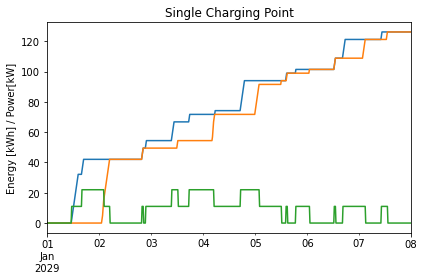

In [23]:
tmp_bands = bands.iloc[:, 0:3]
tmp_bands.rename(columns={col:col.split('_')[0] for col in tmp_bands.columns}, inplace=True)
ax = tmp_bands.plot(legend=False)
plt.ylabel('Energy [kWh] / Power[kW]')
plt.title('Single Charging Point')
plt.tight_layout()
plt.savefig('plots/energy_bands_single_cp.pdf')

In [13]:
columns_upper = [col for col in bands.columns if 'upper' in col]
columns_lower = [col for col in bands.columns if 'lower' in col]
columns_power = [col for col in bands.columns if 'power' in col]

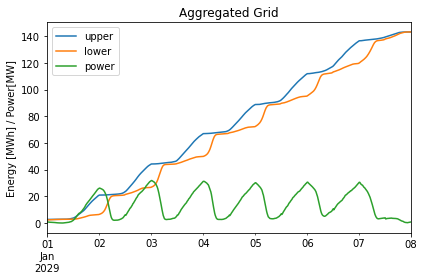

In [24]:
aggregated_bands = pd.DataFrame()
aggregated_bands['upper'] = bands[columns_upper].sum(axis=1)
aggregated_bands['lower'] = bands[columns_lower].sum(axis=1)
aggregated_bands['power'] = bands[columns_power].sum(axis=1)
(aggregated_bands/1e3).plot()
plt.ylabel('Energy [MWh] / Power[MW]')
plt.title('Aggregated Grid')
plt.tight_layout()
plt.savefig('plots/energy_bands_grid.pdf')

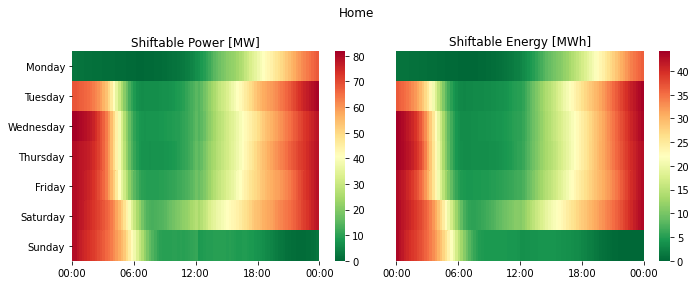

In [14]:
df_power = aggregated_bands['power'].iloc[:-1]/1e3
df_energy = (aggregated_bands['upper'].iloc[:-1] - aggregated_bands['lower'].iloc[:-1])/1e3
filename = 'plots/{}.pdf'.format(use_case)
plot_hm_quarterly(df_power, df_energy, title=use_case.capitalize())

In [15]:
use_case = 'work'
flexibility_bands = pd.read_csv('grid_data/ev_flexibility_bands_{}.csv'.format(use_case), index_col=0)
timeindex = pd.date_range('2029-01-01', '2029-01-08', freq='15min')
bands = flexibility_bands.iloc[0:673].set_index(timeindex)
bands.head()

,upper_8325011_0,lower_8325011_0,power_8325011_0,upper_8325049_0,lower_8325049_0,power_8325049_0,upper_8325060_0,lower_8325060_0,power_8325060_0,upper_8325069_0,...,power_8325049_1124,upper_8325049_1126,lower_8325049_1126,power_8325049_1126,upper_8325049_1128,lower_8325049_1128,power_8325049_1128,upper_8325049_1130,lower_8325049_1130,power_8325049_1130
2029-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,14.85,12.375,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,14.85,14.850,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,14.85,14.850,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,14.85,14.850,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2029-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,14.85,14.850,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
columns_upper = [col for col in bands.columns if 'upper' in col]
columns_lower = [col for col in bands.columns if 'lower' in col]
columns_power = [col for col in bands.columns if 'power' in col]

<AxesSubplot:>

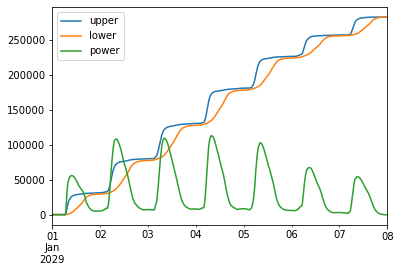

In [17]:
aggregated_bands = pd.DataFrame()
aggregated_bands['upper'] = bands[columns_upper].sum(axis=1)
aggregated_bands['lower'] = bands[columns_lower].sum(axis=1)
aggregated_bands['power'] = bands[columns_power].sum(axis=1)
aggregated_bands.plot()

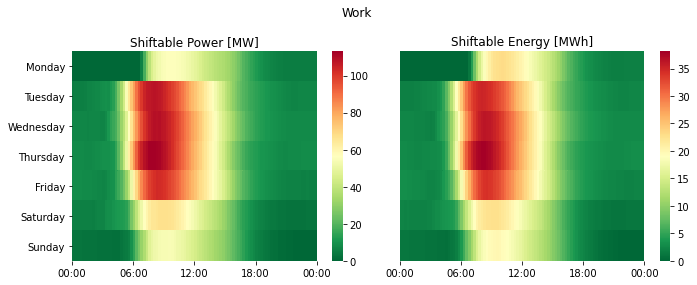

In [18]:
df_power = aggregated_bands['power'].iloc[:-1]/1e3
df_energy = (aggregated_bands['upper'].iloc[:-1] - aggregated_bands['lower'].iloc[:-1])/1e3
plot_hm_quarterly(df_power, df_energy, title=use_case.capitalize())

# Optimise operation of flexibility options

In [5]:
grid_id = 1056

In [6]:
data_dir = Path( # TODO: set dir
    r"\\192.168.10.221\Daten_flexibel_02\simbev_results\Electrification_2050_simbev_run\cp_standing_times_mapping",
    # r"/home/local/RL-INSTITUT/kilian.helfenbein/RLI_simulation_results/simbev_results",
)
edisgo_dir = r'\\192.168.10.221\Daten_flexibel_02\simbev_results\eDisGo_object_files_full\Electrification_2050\1056\reduced'

In [7]:
edisgo_obj = import_edisgo_from_files(edisgo_dir, import_timeseries=True)

In [10]:
flexibility_bands_home = \
    pd.read_csv('grid_data/ev_flexibility_bands_home.csv', index_col=0)
flexibility_bands_work = \
    pd.read_csv('grid_data/ev_flexibility_bands_work.csv', index_col=0)
flexibility_bands = pd.concat([flexibility_bands_work, flexibility_bands_home],
                              axis=1)
cp_mapping_dir = r'\\192.168.10.221\Daten_flexibel_02\simbev_results\Electrification_2050_simbev_run\eDisGo_charging_time_series\{}'.format(grid_id)
mapping_home = \
    gpd.read_file(cp_mapping_dir + '\cp_data_home_within_grid_{}.geojson'.
                  format(grid_id)).set_index('edisgo_id')
mapping_work = \
    gpd.read_file(cp_mapping_dir + '\cp_data_work_within_grid_{}.geojson'.
                  format(grid_id)).set_index('edisgo_id')
mapping = pd.concat([mapping_work, mapping_home])

c:\users\anya.heider\appdata\local\continuum\miniconda3\envs\edisgo_env\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [11]:
len(mapping), len(flexibility_bands.columns)

(3461, 10383)

In [13]:
check_mapping(mapping, edisgo_obj, flexibility_bands)

In [16]:
downstream_node_matrix = pd.read_csv('grid_data/downstream_node_matrix.csv', index_col=0)

In [17]:
timesteps= pd.date_range('2029-01-01', '2029-01-08', freq='15min')
flexibility_bands = flexibility_bands.iloc[:len(timesteps)].set_index(timesteps)
model = setup_model(edisgo_obj, downstream_node_matrix, timesteps, optimize_storage=False,
                        mapping_cp=mapping, energy_band_charging_points=flexibility_bands)

MemoryError: Unable to allocate 3.43 GiB for an array with shape (13148, 35040) and data type object